In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numexpr as ne
import math
from IPython.display import display, Math, HTML
import matplotlib.animation as animation
from scipy.optimize import curve_fit

In [2]:
!rm neutronsrf.pyf
!python3 -m numpy.f2py neutronsrf.f90 -m neutronsrf -h neutronsrf.pyf
!python3 -m numpy.f2py -c neutronsrf.pyf neutronsrf.f90

Reading fortran codes...
	Reading file 'neutronsrf.f90' (format:free)
Post-processing...
	Block: neutronsrf
			Block: neutronsrf
				Block: initial
				Block: mc_step_inelastic
				Block: deallocate_
Post-processing (stage 2)...
	Block: neutronsrf
		Block: unknown_interface
			Block: neutronsrf
				Block: initial
				Block: mc_step_inelastic
				Block: deallocate_
Saving signatures to file "./neutronsrf.pyf"
{'attrspec': ['public']}
In: :neutronsrf:neutronsrf.f90:neutronsrf
vars2fortran: No typespec for argument "initial".
{'attrspec': ['public']}
In: :neutronsrf:neutronsrf.f90:neutronsrf
vars2fortran: No typespec for argument "mc_step_inelastic".
{'attrspec': ['public']}
In: :neutronsrf:neutronsrf.f90:neutronsrf
vars2fortran: No typespec for argument "deallocate_".
running build
running config_cc
unifing config_cc, config, build_clib, build_ext, build commands --compiler options
running config_fc
unifing config_fc, config, build_clib, build_ext, build commands --fcompiler options
runn

In [3]:
from neutronsrf import neutronsrf

# Neutron transport

We now consider the application of a nonuniform probability distribution to the simulation of the
transmission of neutrons through bulk matter, one of the original applications of a Monte Carlo
method. Suppose that a neutron is incident on a plate of thickness $t$. We assume that the plate is
infinite in the $x$ and $y$ directions and that the $z$ axis is normal to the plate. At any point within
the plate, the neutron can either be captured with probability pc or scattered with probability
ps. These probabilities are proportional to the capture cross section and scattering cross section,
respectively. If the neutron is scattered, we need to find its new direction as specified by the polar
angle $\theta$ (see Figure 11.5). Because we are not interested in how far the neutron moves in the $x$ or
$y$ direction, the value of the azimuthal angle $\phi$ is irrelevant.

If the neutrons are scattered equally in all directions, then the probability $p(\theta, \phi) d\theta d\phi$ equals
$\frac{d\Omega}{4\pi}$, where $d\Omega$ is an infinitesimal solid angle and $4\pi$ is the total solid angle. Because $d\Omega =
sin \theta d\theta d\phi$, we have
$$p(\theta, \phi) = \frac{\text{sin}\theta}{4\pi} .$$

We can find the probability density for $\theta$ and $\phi$ separately by integrating over the other angle. For
example,
$$p(\theta) = \int^{2\pi}_{0}p(\theta, \phi) d\phi = \frac{1}{2}\text{sin} \theta,$$
and
$$p(\phi) = \int^{\pi}_{0}p(\theta, \phi) d\theta = \frac{1}{2\pi}. $$

Because the point probability $p(\theta, \phi)$ is the product of the probabilities $p(\theta)$ and $p(\phi)$, θ and $\phi$ are
independent variables. Although we do not need to generate a random angle φ, we note that since
$p(\phi)$ is a constant, $\phi$ can be found from the relation
$$\theta = 2\pi r.$$ (11.40)
To find $\theta$ according to the distribution (11.38), we substitute (11.38) in (11.24) and obtain
$$r = \frac{1}{2} \int^\theta _0\text{sin}x dx$$
If we do the integration in (11.41), we find
$$\text{cos} \theta = 1 − 2r.$$ 
Note that (11.40) implies that $\phi$ is uniformly distributed between $0$ and $2\pi$ and (11.42) implies
that $\text{cos}\ \theta$ is uniformly distributed between $−1$ and $+1$.
We could invert the cosine in (11.42) to solve for $\theta$. However, to find the $z$ component of the
path of the neutron through the plate, we need to multiply $\text{cos} \theta$ by the path length , and hence
we need $\text{cos} \theta$ rather than $\theta$. The path length, which is the distance traveled between subsequent
scattering events, is obtained from the exponential probability density, $p(l) \propto e^{−l/λ}$ (see (11.28)).
From (11.30), we have
$$ \mathcal{l} = −\lambda ln r,$$
where $\lambda$ is the mean free path.

Now we have all the necessary ingredients for calculating the probabilities for a neutron to
pass through the plate, be reflected off the plate, or be captured and absorbed in the plate. The
input parameters are the thickness of the plate $t$, the capture and scattering probabilities $p_c$ and
$p_s$, and the mean free path $\lambda$. We begin with $z = 0$, and implement the following steps:
1. Determine if the neutron is captured or scattered. If it is captured, then add one to the number of captured neutrons, and go to step 5.
2. If the neutron is scattered, compute $\text{cos} \theta$ from (11.42) and $l$ from (11.43). Change the $z$ coordinate of the neutron by  $\text{cos} \theta l$.
3. If $z < 0$, add one to the number of reflected neutrons. If $z>t$, add one to the number of transmitted neutrons. In either case, skip to step 5 below.
4. Repeat steps 1–3 until the fate of the neutron has been determined.
5. Repeat steps 1–4 with additional incident neutrons until sufficient data has been obtained.

In [4]:
class Neutron_scattering:
    '''
    This class implements 
    the neutron scattering
    '''
    
    def __init__(self, N_p, t, p_s, lambda_ = None, fraction = None, energy = None, seed = 50, store = False):
        'Initialize the neutron scattering'
        self.N_p = N_p #Number of neutrons
        self.z = np.zeros(N_p) #Cartesian coordinates for each neutron
        self.y = np.zeros(N_p)
        self.x = np.zeros(N_p)
        self.N_r = 0 #Number of reflected neutrons
        self.N_t = 0 #Number of transmitted neutrons
        self.N_a = 0 #Number of absorbed neutrons
        self.N_s = 0 #Scattering events
        self.free_path = [] #Free path for each scattering event
        self.t = t #Target thickness
        self. lambda_ = lambda_ #Mean free path
        self.p_c = 1-p_s #Capture and scattering probabilities
        self.p_s = p_s
        self.energy = energy #Initial energy of neutrons
        self.fraction = fraction #Fraction of energy lost in each scattering event
        self.rng = np.random.default_rng(seed)
        self.store = store
    
    def MC_step(self):
        'Monte Carlo dynamics'
        for i in range(self.N_p): #Choose a neutron
            if self.store:
                f = open("output{:02}.txt".format(i), "a")
                f.truncate(0)
                print(0, 0, -0.25, file = f) #We suppose that the beam starts 0.25 cm from the target
                print(0, 0, 0, file = f) #The beam is perpendicular to the target and the first event happens in the origin
            exit = False
            while exit == False:
                rnd = self.rng.random()
                if rnd <= self.p_s: #There's a p_s% probability to have a scattering event
                    self.N_s = self.N_s + 1 #Scattering event counter increments
                    rnd_ = self.rng.random(3)
                    l = - self.lambda_ * np.log(rnd_[0]) #Generate the path length according to an exponential distribution
                    self.free_path.append(l)
                    phi = 2 * np.pi * rnd_[1] #Generate the azimuthal angle phi according to a uniform distribution in [0, 2\pi]
                    cos_theta = 1 - 2 * rnd_[2] #Generate the unitary projection according to a uniform distribution in [-0.5, 0.5]
                    theta = np.arccos(cos_theta)
                    self.z[i] = l * cos_theta + self.z[i] #Corrisponding z coordinate
                    if self.store:
                        self.x[i] = l * np.sin(theta) * np.cos(phi) + self.x[i]
                        self.y[i] = l * np.sin(theta) * np.sin(phi) + self.y[i]
                        print(self.x[i], self.y[i], self.z[i], file=f)
                    if self.z[i] < 0: #Check if the particle has been reflected
                        self.N_r += 1
                        exit = True
                    if self.z[i] > self.t: #Check if the particle has been transmitted
                        self.N_t = self.N_t+1
                        exit = True
                else: #There's a (1-p_s)% probability to have absorption
                    self.N_a = self.N_a+1
                    exit = True
            if self.store:
                f.close()
            
    def MC_step_inelastic(self):
        'Monte Carlo dynamics inelastic'
        for i in range(self.N_p):
            E = self.energy #Each neutron has the same initial energy
            if self.store:
                f = open("output{:02}.txt".format(i), "a")
                f.truncate(0)
                print(0, 0, -0.25, file=f)
                print(0, 0, 0, file=f)
            exit = False
            while exit == False:
                rnd = self.rng.random()
                if rnd <= self.p_s:
                    self.N_s = self.N_s + 1
                    E = (1 - self.fraction) * E #Energy decrement
                    rnd_ = self.rng.random(3)
                    l = - np.sqrt(E) * np.log(rnd_[0])
                    self.free_path.append(l)
                    phi = 2 * np.pi * rnd_[1]
                    cos_theta = 1 - 2 * rnd_[2]
                    theta = np.arccos(cos_theta)
                    self.z[i] = l * cos_theta + self.z[i]
                    if self.store:
                        self.x[i] = l * np.sin(theta) * np.cos(phi) + self.x[i]
                        self.y[i] = l * np.sin(theta) * np.sin(phi) + self.y[i]
                        print(self.x[i], self.y[i], self.z[i], file = f)
                    if self.z[i] < 0:
                        self.N_r += 1
                        exit = True
                    if self.z[i] > self.t:
                        self.N_t = self.N_t + 1
                        exit = True
                else:
                    self.N_a = self.N_a + 1
                    exit = True
            if self.store:
                f.close()
            
    
    def get_stats(self,display=True):
        '''
        Calculate, store and print 
        statistical quantities
        '''
        self.p_refr = self.N_r/self.N_p
        self.p_tras = self.N_t/self.N_p
        self.p_abso = self.N_a/self.N_p

## Elastic neutron scattering

- (a) Write a program to implement the above algorithm for neutron scattering through a plate. Assume $t = 1$ and $p_c = p_s/2$. Find the transmission, reflection, and absorption probabilities for the mean free path $\lambda$ equal to 0.01, 0.05, 0.1, 1, and 10. Begin with 100 incident neutrons, and increase this number until satisfactory statistics are obtained. Give a qualitative explanation of your results.

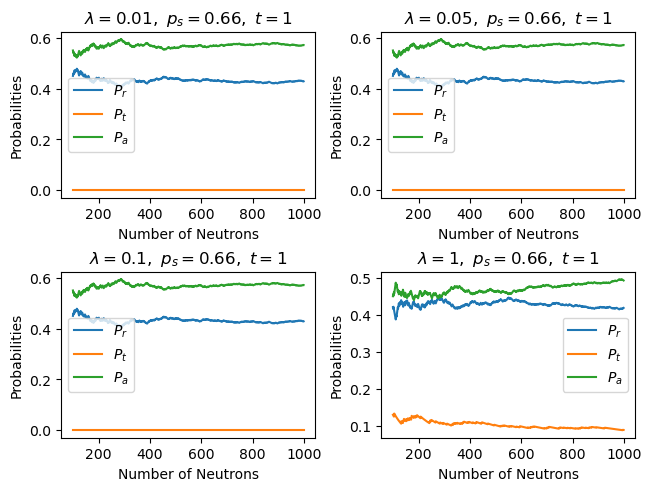

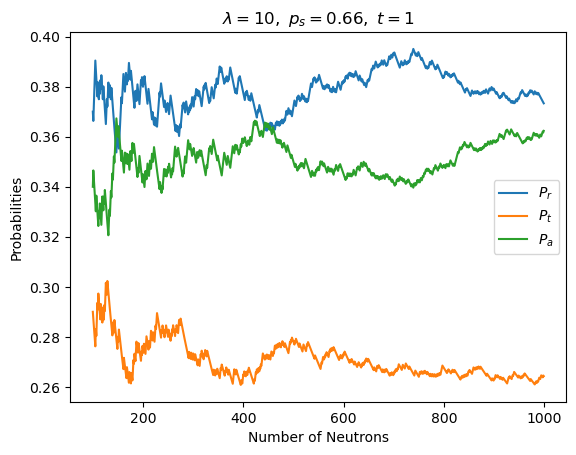

In [5]:
fig, axs = plt.subplots(ncols = 2, nrows = 2, layout = "constrained")

k = 0
l = 0

for j in [0.01, 0.05, 0.1, 1]:
    P_r=[]
    P_t=[]
    P_a=[]
    N_p=[]
    for i in range(100,1000):
        N_S=Neutron_scattering(i, 1, lambda_ = j, p_s = 2/3)
        N_S.MC_step()
        N_S.get_stats()
        P_r.append(N_S.p_refr)
        P_t.append(N_S.p_tras)
        P_a.append(N_S.p_abso)
        N_p.append(i)
    
    axs[k,l].title.set_text("$\lambda={},\ p_s = 0.66,\ t = 1$".format(j))
    axs[k,l].set_xlabel("Number of Neutrons")
    axs[k,l].set_ylabel("Probabilities")
    axs[k,l].plot(N_p, P_r, label = '$P_r$')
    axs[k,l].plot(N_p, P_t, label = '$P_t$')
    axs[k,l].plot(N_p, P_a, label = '$P_a$')
    axs[k,l].legend()
    if k == 0:
        if l == 0:
            l = l + 1
        else:
            k = k + 1
            l = 0
    else:
        if l == 0:
            l = 1 
plt.show()
            
            
P_r=[]
P_t=[]
P_a=[]
N_p=[]
for i in range(100,1000):
    N_S=Neutron_scattering(i, 1, lambda_ = 10, p_s = 2/3)
    N_S.MC_step()
    N_S.get_stats()
    P_r.append(N_S.p_refr)
    P_t.append(N_S.p_tras)
    P_a.append(N_S.p_abso)
    N_p.append(i)
    
plt.title("$\lambda={},\ p_s = 0.66,\ t = 1$".format(10))
plt.xlabel("Number of Neutrons")
plt.ylabel("Probabilities")
plt.plot(N_p,P_r,label='$P_r$')
plt.plot(N_p,P_t,label='$P_t$')
plt.plot(N_p,P_a,label='$P_a$')
plt.legend()
plt.show()

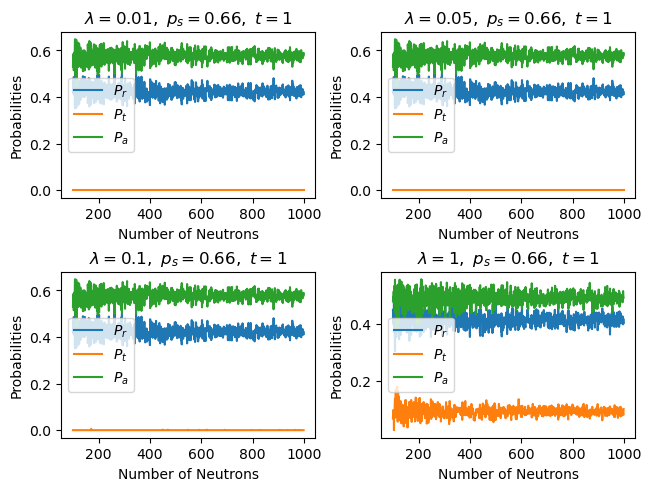

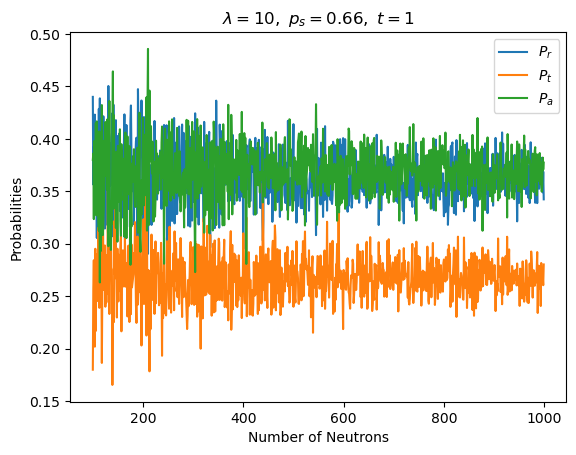

In [6]:
fig, axs = plt.subplots(ncols = 2, nrows = 2, layout = "constrained")

k = 0
l = 0

for j in [0.01, 0.05, 0.1, 1]:
    P_r=[]
    P_t=[]
    P_a=[]
    N_p=[]
    for i in range(100,1000):
        N_S=Neutron_scattering(i, 1, lambda_ = j, p_s = 2/3, seed = i)
        N_S.MC_step()
        N_S.get_stats()
        P_r.append(N_S.p_refr)
        P_t.append(N_S.p_tras)
        P_a.append(N_S.p_abso)
        N_p.append(i)
    
    axs[k,l].title.set_text(("$\lambda={},\ p_s = 0.66,\ t = 1$".format(j)))
    axs[k,l].set_xlabel("Number of Neutrons")
    axs[k,l].set_ylabel("Probabilities")
    axs[k,l].plot(N_p, P_r, label = '$P_r$')
    axs[k,l].plot(N_p, P_t, label = '$P_t$')
    axs[k,l].plot(N_p, P_a, label = '$P_a$')
    axs[k,l].legend()
    if k == 0:
        if l == 0:
            l = l + 1
        else:
            k = k + 1
            l = 0
    else:
        if l == 0:
            l = 1 
plt.show()
            
            
P_r=[]
P_t=[]
P_a=[]
N_p=[]
for i in range(100,1000):
    N_S=Neutron_scattering(i, 1, lambda_ = 10, p_s = 2/3, seed = i)
    N_S.MC_step()
    N_S.get_stats()
    P_r.append(N_S.p_refr)
    P_t.append(N_S.p_tras)
    P_a.append(N_S.p_abso)
    N_p.append(i)
    
plt.title("$\lambda={},\ p_s = 0.66,\ t = 1$".format(10))
plt.xlabel("Number of Neutrons")
plt.ylabel("Probabilities")
plt.plot(N_p,P_r,label='$P_r$')
plt.plot(N_p,P_t,label='$P_t$')
plt.plot(N_p,P_a,label='$P_a$')
plt.legend()
plt.show()

We have plotted the probabilities, in two different ways: in the first case we have considered the same seed, thus the maximum variation is limited, in the second case we change the seed for each run.  
The results we got show that changing the seed means having noisier plots.  
Besides, we see that the overall behaviour is similar in the two cases.  
In particular, increasing $\lambda$ lifts transmission and reflection probabilities, this results in a decrease of the capture probability.  
We could wonder why the capture probability is not what we expect, i.e. $p_c$, the reason is due to the finite target thickness $t$, the finite size doesn't allow neutrons whose directions should reflect or transmit them to be reflected.  
Infact, as we increase $\lambda$, the capture probability tends to its value $p_c=0.33$.

- (b) Choose $t = 1$, $p_c = p_s$, and $\lambda = 0.05$, and compare your results with the analogous case considered in part (a).

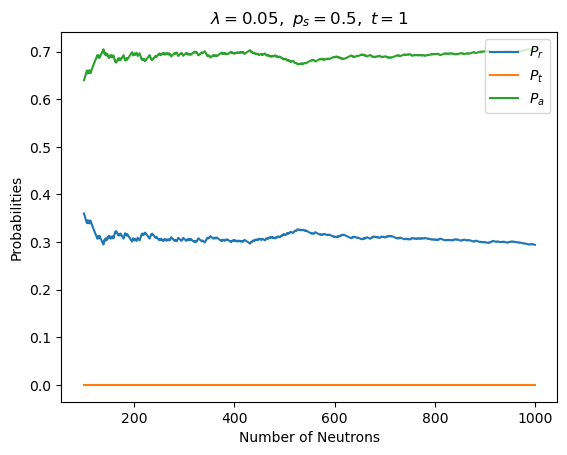

In [7]:
P_r=[]
P_t=[]
P_a=[]
N_p=[]
for i in range(100, 1000):
    N_S=Neutron_scattering(i, 1, lambda_ = 0.05, p_s = 1/2)
    N_S.MC_step()
    N_S.get_stats()
    P_r.append(N_S.p_refr)
    P_t.append(N_S.p_tras)
    P_a.append(N_S.p_abso)
    N_p.append(i)
    
plt.title("$\lambda={},\ p_s = 0.5,\ t = 1$".format(0.05))
plt.xlabel("Number of Neutrons")
plt.ylabel("Probabilities")
plt.plot(N_p,P_r,label='$P_r$')
plt.plot(N_p,P_t,label='$P_t$')
plt.plot(N_p,P_a,label='$P_a$')
plt.legend()
plt.show()

As we could expect, decreasing the scatter probability results in favour of the capture probability: the number of reflected and transmitted particles decreases, while the captured ones increases.

- (c) Repeat part (b) with $t = 2$ and $\lambda = 0.1$. Do the various probabilities depend on $\lambda$ and $t$ separately or only on their ratio? Answer this question before doing the simulation.

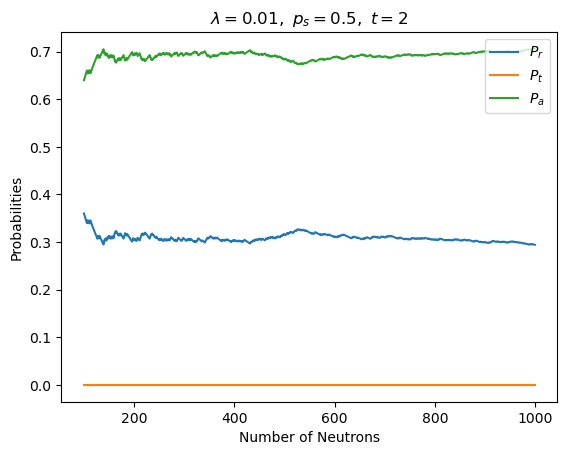

In [8]:
P_r=[]
P_t=[]
P_a=[]
N_p=[]
for i in range(100, 1000):
    N_S=Neutron_scattering(i, 2, lambda_ = 0.01, p_s = 1/2)
    N_S.MC_step()
    N_S.get_stats()
    P_r.append(N_S.p_refr)
    P_t.append(N_S.p_tras)
    P_a.append(N_S.p_abso)
    N_p.append(i)
    
plt.title("$\lambda={},\ p_s = 0.5,\ t = 2$".format(0.01))
plt.xlabel("Number of Neutrons")
plt.ylabel("Probabilities")
plt.plot(N_p,P_r,label='$P_r$')
plt.plot(N_p,P_t,label='$P_t$')
plt.plot(N_p,P_a,label='$P_a$')
plt.legend()
plt.show()

We see that the two plots coincide: this is due to the fact that both transmission and reflection probability are proportional to $\lambda/t$.  
Infact the transmission of a particle (such as the reflection) is inversely proportional to the target thickness and --indipendently-- proportional to the mean path length. This results in a $\lambda/t$ proportionality.  
Since in these cases the ratio $\lambda/t$ is the same, the probabilities are equal.

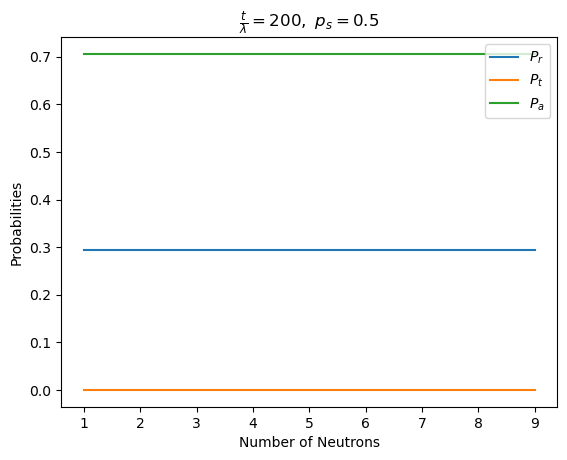

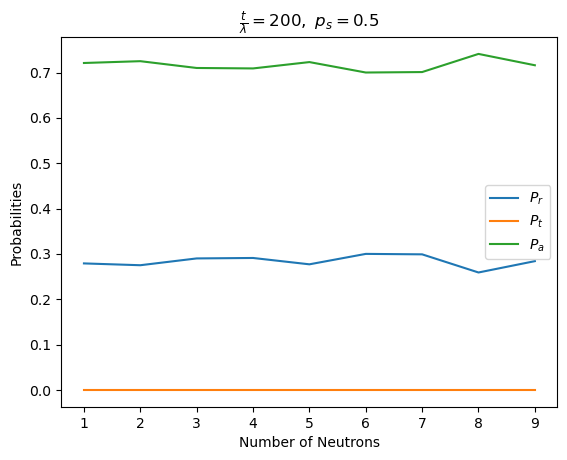

In [9]:
P_r = []
P_t = []
P_a = []
N_p = []

ratio = 200

for i in range(1, 10):
    lambda_ = i/ratio
    N_S = Neutron_scattering(1000, i, lambda_ = lambda_, p_s = 1/2)
    N_S.MC_step()
    N_S.get_stats()
    P_r.append(N_S.p_refr)
    P_t.append(N_S.p_tras)
    P_a.append(N_S.p_abso)
    N_p.append(i)
    
plt.title(r"$\frac{t}{\lambda}=200,\ p_s = 0.5$")
plt.xlabel("Number of Neutrons")
plt.ylabel("Probabilities")
plt.plot(N_p, P_r, label = '$P_r$')
plt.plot(N_p, P_t, label = '$P_t$')
plt.plot(N_p, P_a, label = '$P_a$')
plt.legend()
plt.show()

P_r = []
P_t = []
P_a = []
N_p = []

ratio = 200

for i in range(1, 10):
    lambda_ = i/ratio
    N_S = Neutron_scattering(1000, i, lambda_ = lambda_, seed = i, p_s = 1/2)
    N_S.MC_step()
    N_S.get_stats()
    P_r.append(N_S.p_refr)
    P_t.append(N_S.p_tras)
    P_a.append(N_S.p_abso)
    N_p.append(i)
    
plt.title(r"$\frac{t}{\lambda}=200,\ p_s = 0.5$")
plt.xlabel("Number of Neutrons")
plt.ylabel("Probabilities")
plt.plot(N_p, P_r, label = '$P_r$')
plt.plot(N_p, P_t, label = '$P_t$')
plt.plot(N_p, P_a, label = '$P_a$')
plt.legend()
plt.show()

We plotted this dependence in two different case: in the first case we considered the same seed, in the second case we changed the seed.  
In the latter case the plot is affected by statistical fluctuations, while in the former we see a perfect constant behaviour.

- (d) Draw some typical paths of the neutrons. From the nature of these paths, explain the results in parts (a)–(c). For example, how does the number of scattering events change as the absorption probability changes?

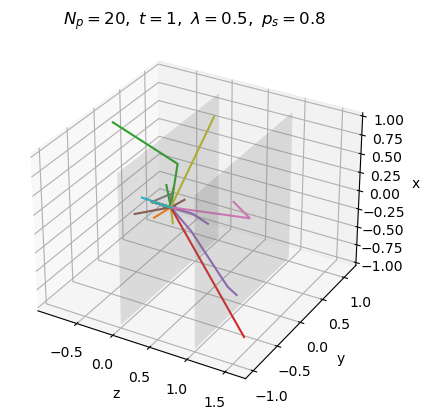

In [10]:
N_S=Neutron_scattering(20, 1, lambda_ = 0.5, p_s = 0.8, store = True)
N_S.MC_step()

fig = plt.figure()
ax = plt.axes(projection ="3d")
plt.title("$N_p=20,\ t=1,\ \lambda=0.5,\ p_s=0.8$")

point  = np.array([0, 0, 0])
normal = np.array([1, 0, 0])
point_  = np.array([1, 0, 0])

# a plane is a*x+b*y+c*z+d=0
# [a,b,c] is the normal. Thus, we have to calculate
# d and we're set
d = -point.dot(normal)
d_ = -point_.dot(normal)

# create x,y
zz, yy = np.meshgrid(np.linspace(-1,1,10), np.linspace(-1,1,10))

# calculate corresponding z
x = (-normal[2] * zz - normal[1] * yy - d) * 1. /normal[0]
x_ = (-normal[2] * zz - normal[1] * yy - d_) * 1. /normal[0]
ax.plot_surface(x, yy, zz, alpha=0.2,color='grey')
ax.plot_surface(x_, yy, zz, alpha=0.2,color='grey')
ax.set_xlabel('z')
ax.set_ylabel('y')
ax.set_zlabel('x')

for i in range(20):
    data = np.genfromtxt('output{:02}.txt'.format(i))
    x = data[:,0]
    y = data[:,1]
    z = data[:,2]
    ax.plot3D(z, y, x)

plt.show()

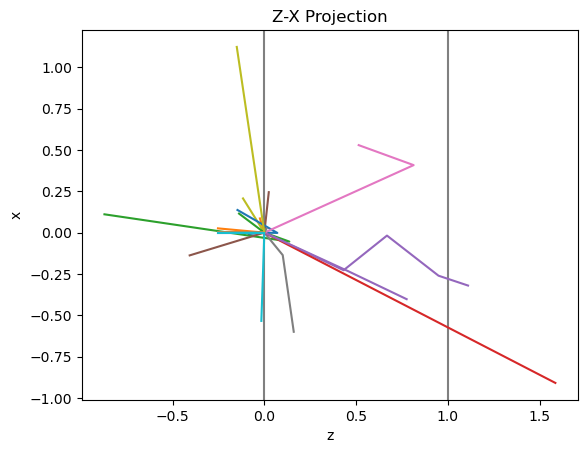

In [11]:
plt.title("Z-X Projection")
plt.xlabel("z")
plt.ylabel("x")
plt.axline((0,0), (0, -0.5), color='grey')
plt.axline((1,0), (1, -0.5), color='grey')

for i in range(20):
    data = np.genfromtxt('output{:02}.txt'.format(i))
    x = data[:,1]
    z = data[:,2]
    plt.plot(z, x)
    
plt.show()

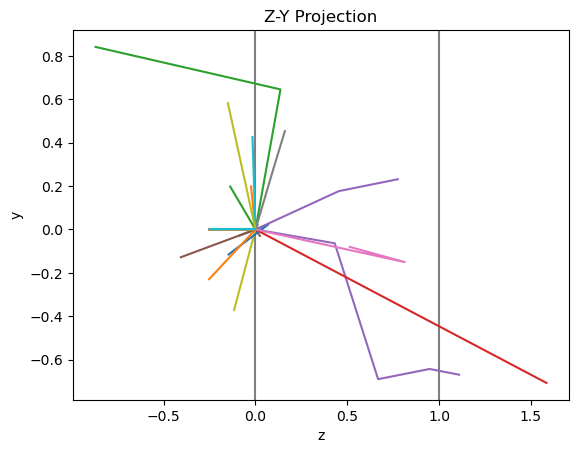

In [12]:
plt.title("Z-Y Projection")
plt.xlabel("z")
plt.ylabel("y")
plt.axline((0,0), (0, -0.5), color='grey')
plt.axline((1,0), (1, -0.5), color='grey')

for i in range(20):
    data = np.genfromtxt('output{:02}.txt'.format(i))
    y = data[:,0]
    z = data[:,2]
    plt.plot(z, y)
    
plt.show()

From these plots we see that the trajectories of neutrons are strongly dependent on the scattering probability and the mean free path.
In the first event, we have (on average) lost half of the particles which have not been captured, the remaining particles continue their trajectory with the same modality, until they get over half t, for which it is more likely to be transmitted.  
This explains why the transmitted part is the smaller.  
The longer the mean free path, the more trajectories will be transmitted.
On the other hand, when we consider shorter mean free path, more neutrons will be reflected or captured, since fewer neutrons will go over the target.
In the latter perspective, i.e. for short mean free path, the number of neutrons reflected is proportional to the scattering probability. Considering smaller $t$ for fixed $\lambda$ is equal to consider bigger $\lambda$ for fixed $t$ and vice-versa.
This means that the transmission and reflection are independent on the particular values of $\lambda$ and $t$, they are dependent on how much one is bigger than the other, i.e. their ratio.   
This explains also the results for $t/\lambda$ costant: the dynamics is not dependent on the scale we are considering and since the only metric values are t and $\lambda$, their ratio--which is scale indipendent (i.e. adimensional)--is related to one and only transmission probability, whose value is dependent on the scattering probability.

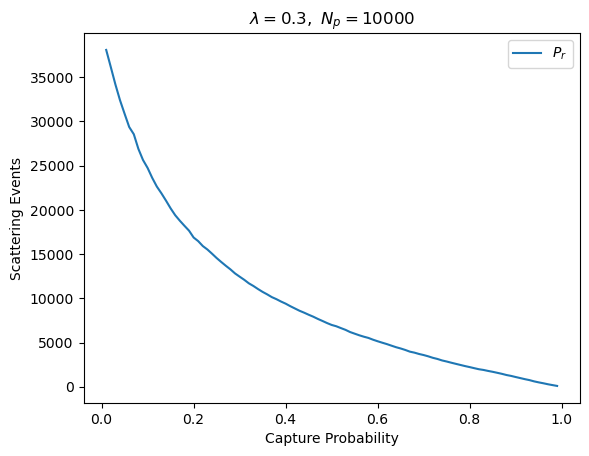

C:\Users\Fabio\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


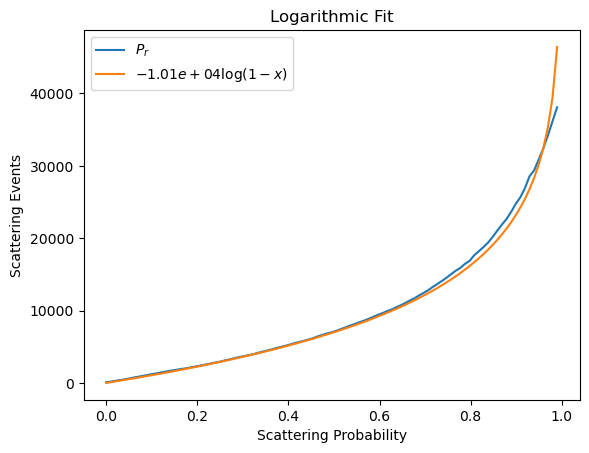

In [13]:
Ns=[]
pc=[]

for i in range(1, 100):
    N_S = Neutron_scattering(10000, 1, lambda_ = 0.3, p_s = i/100)
    N_S.MC_step()
    N_S.get_stats()
    Ns.append(N_S.N_s)
    pc.append(1-i/100)
    
plt.title(r"${\lambda}=0.3,\ N_p=10000$")
plt.xlabel("Capture Probability")
plt.ylabel("Scattering Events")
plt.plot(pc, Ns, label = '$P_r$')
plt.legend()
plt.show()

def log(x,a,b):
    return -a*np.log((1-x))

x_interval_for_fit = np.linspace(0, 1, 100)

popt, _ = curve_fit(log, x_interval_for_fit[:-1], Ns)

plt.title('Logarithmic Fit')
plt.xlabel("Scattering Probability")
plt.ylabel("Scattering Events")
plt.plot(x_interval_for_fit[:-1], Ns, label = '$P_r$')
plt.plot(x_interval_for_fit[:-1], log(x_interval_for_fit[:-1], *popt), label = '$-{:.3}$log($1-x$)'.format(popt[0]))
plt.legend()
plt.show()

As we have seen, the probability of capture balances the probability of scattering.  
For this reason, the number of scattering events is proportional to the scattering probability (clearly) and consequently it is inversely proportional to the capture probability.  
From the results above we can even infere a log-like behaviour.

## Inelastic neutron scattering
- (a) We assumed elastic scattering, that is, no energy is lost during scattering. Here we assume that some of the neutron energy $E$ is lost and that the mean free path is proportional to the speed and hence to $\sqrt{E}$. Modify your program so that a neutron loses a fraction $f$ of its energy at each scattering event, and assume that $\lambda = \sqrt{E}$. Consider $f$ = 0.05, 0.1, and 0.5, and compare your results with those found previously.

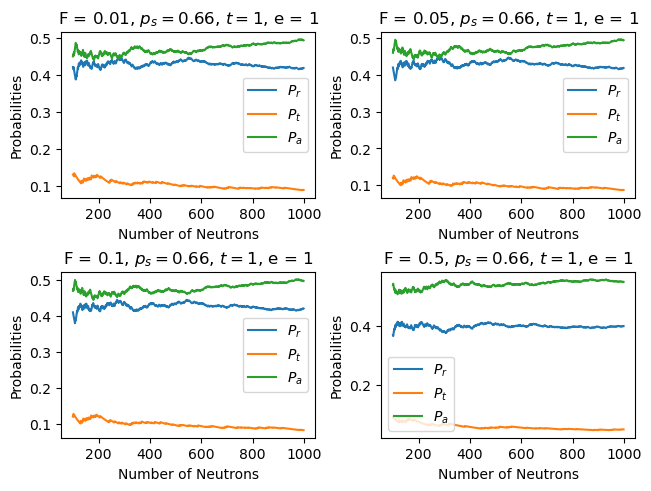

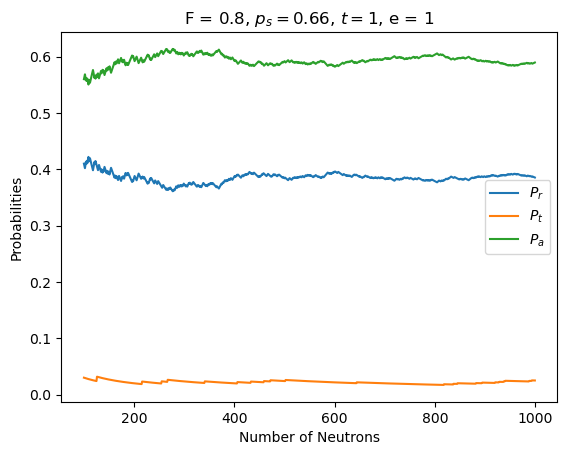

In [14]:
fig, axs = plt.subplots(ncols=2, nrows=2,layout="constrained")

k = 0
l = 0

for j in [0.01, 0.05, 0.1, 0.5]:
    P_r = []
    P_t = []
    P_a = []
    N_p = []
    for i in range(100, 1000):
        N_S=Neutron_scattering(i, 1, fraction = j, p_s = 2/3, energy = 1)
        N_S.MC_step_inelastic()
        N_S.get_stats()
        P_r.append(N_S.p_refr)
        P_t.append(N_S.p_tras)
        P_a.append(N_S.p_abso)
        N_p.append(i)
    
    axs[k,l].title.set_text("F = {}, $p_s = 0.66$, $t=1$, e = 1".format(j))
    axs[k,l].set_xlabel("Number of Neutrons")
    axs[k,l].set_ylabel("Probabilities")
    axs[k,l].plot(N_p, P_r, label = '$P_r$')
    axs[k,l].plot(N_p, P_t, label = '$P_t$')
    axs[k,l].plot(N_p, P_a, label = '$P_a$')
    axs[k,l].legend()
    if k == 0:
        if l == 0:
            l = l + 1
        else:
            k = k + 1
            l = 0
    else:
        if l == 0:
            l = 1
            
plt.show()
            
P_r=[]
P_t=[]
P_a=[]
N_p=[]
for i in range(100, 1000):
    N_S=Neutron_scattering(i, 1, fraction = 0.7, p_s = 2/3, energy = 1)
    N_S.MC_step_inelastic()
    N_S.get_stats()
    P_r.append(N_S.p_refr)
    P_t.append(N_S.p_tras)
    P_a.append(N_S.p_abso)
    N_p.append(i)
    
plt.title("F = {}, $p_s = 0.66$, $t=1$, e = 1".format(0.8))
plt.xlabel("Number of Neutrons")
plt.ylabel("Probabilities")
plt.plot(N_p,P_r,label='$P_r$')
plt.plot(N_p,P_t,label='$P_t$')
plt.plot(N_p,P_a,label='$P_a$')
plt.legend()
plt.show()

As we could expect, the number of captured neutrons increases as the fraction of energy lost increases.
Infact, as a neutron is slowed down, it will undergo more scattering, since the mean free path is proportional to energy: from the previous analysis, this means a higher capture probability.

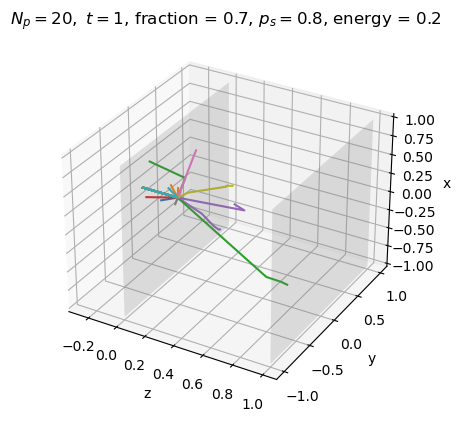

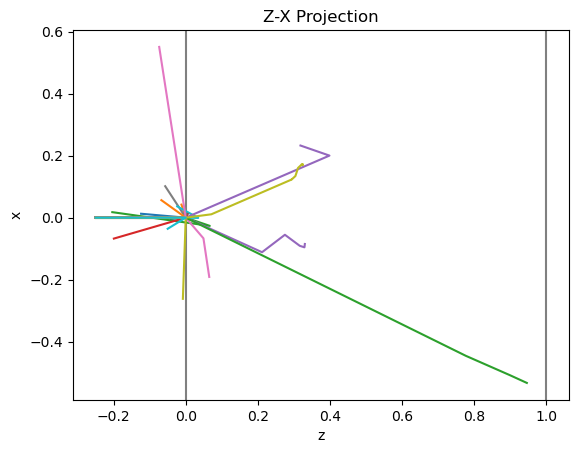

In [15]:
N_S=Neutron_scattering(20, 1, fraction = 0.7, p_s = 0.8, energy = 0.2, store = True)
N_S.MC_step_inelastic()

fig = plt.figure()
ax = plt.axes(projection ="3d")
plt.title('$N_p=20,\ t=1$, fraction = 0.7, $p_s=0.8$, energy = 0.2')

point  = np.array([0, 0, 0])
normal = np.array([1, 0, 0])
point_  = np.array([1, 0, 0])

# a plane is a*x+b*y+c*z+d=0
# [a,b,c] is the normal. Thus, we have to calculate
# d and we're set
d = -point.dot(normal)
d_ = -point_.dot(normal)

# create x,y
zz, yy = np.meshgrid(np.linspace(-1,1,10), np.linspace(-1,1,10))

# calculate corresponding z
x = (-normal[2] * zz - normal[1] * yy - d) * 1. /normal[0]
x_ = (-normal[2] * zz - normal[1] * yy - d_) * 1. /normal[0]
ax.plot_surface(x, yy, zz, alpha=0.2,color='grey')
ax.plot_surface(x_, yy, zz, alpha=0.2,color='grey')
ax.set_xlabel('z')
ax.set_ylabel('y')
ax.set_zlabel('x')

for i in range(20):
    data = np.genfromtxt('output{:02}.txt'.format(i))
    x = data[:,0]
    y = data[:,1]
    z = data[:,2]
    ax.plot3D(z, y, x)

plt.show()

plt.title("Z-X Projection")
plt.xlabel("z")
plt.ylabel("x")
plt.axline((0,0), (0, -0.5), color='grey')
plt.axline((1,0), (1, -0.5), color='grey')

for i in range(20):
    data = np.genfromtxt('output{:02}.txt'.format(i))
    x = data[:,1]
    z = data[:,2]
    plt.plot(z, x)
    
plt.show()

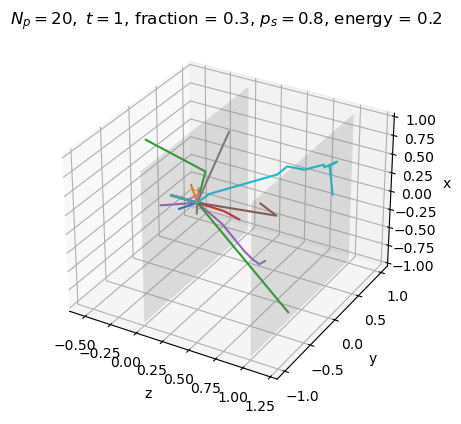

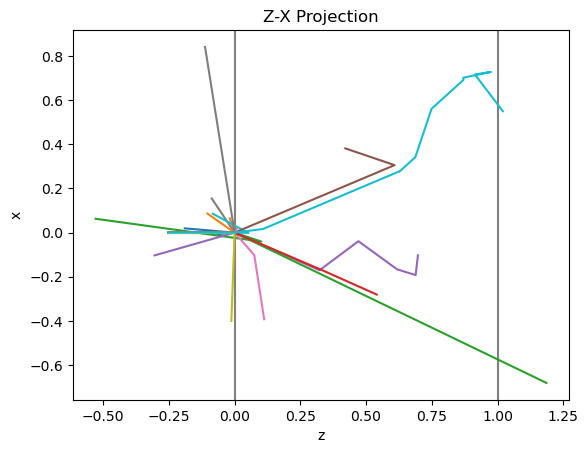

In [16]:
N_S=Neutron_scattering(20, 1, fraction = 0.3, p_s = 0.8, energy = 0.2, store = True)
N_S.MC_step_inelastic()

fig = plt.figure()
ax = plt.axes(projection ="3d")
plt.title('$N_p=20,\ t=1$, fraction = 0.3, $p_s=0.8$, energy = 0.2')

point  = np.array([0, 0, 0])
normal = np.array([1, 0, 0])
point_  = np.array([1, 0, 0])

# a plane is a*x+b*y+c*z+d=0
# [a,b,c] is the normal. Thus, we have to calculate
# d and we're set
d = -point.dot(normal)
d_ = -point_.dot(normal)

# create x,y
zz, yy = np.meshgrid(np.linspace(-1,1,10), np.linspace(-1,1,10))

# calculate corresponding z
x = (-normal[2] * zz - normal[1] * yy - d) * 1. /normal[0]
x_ = (-normal[2] * zz - normal[1] * yy - d_) * 1. /normal[0]
ax.plot_surface(x, yy, zz, alpha=0.2,color='grey')
ax.plot_surface(x_, yy, zz, alpha=0.2,color='grey')
ax.set_xlabel('z')
ax.set_ylabel('y')
ax.set_zlabel('x')

for i in range(20):
    data = np.genfromtxt('output{:02}.txt'.format(i))
    x = data[:,0]
    y = data[:,1]
    z = data[:,2]
    ax.plot3D(z, y, x)

plt.show()

plt.title("Z-X Projection")
plt.xlabel("z")
plt.ylabel("x")
plt.axline((0,0), (0, -0.5), color='grey')
plt.axline((1,0), (1, -0.5), color='grey')

for i in range(20):
    data = np.genfromtxt('output{:02}.txt'.format(i))
    x = data[:,1]
    z = data[:,2]
    plt.plot(z, x)
    
plt.show()

From these plots it's clear that as the fraction of energy lost grows, the neutron paths are shorter.

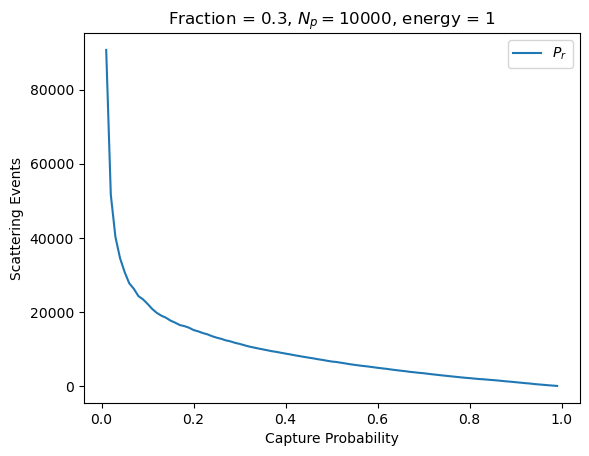

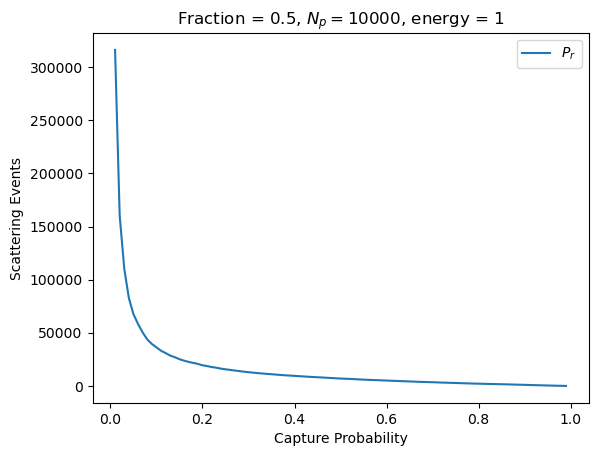

In [17]:
Ns=[]
pc=[]

for i in range(1, 100):
    N_S=Neutron_scattering(10000, 1, fraction = 0.3, p_s = i/100, energy = 1)
    N_S.MC_step_inelastic()
    N_S.get_stats()
    Ns.append(N_S.N_s)
    pc.append(1-i/100)
    
plt.title(r"Fraction = 0.3, $N_p=10000$, energy = 1")
plt.xlabel("Capture Probability")
plt.ylabel("Scattering Events")
plt.plot(pc, Ns, label = '$P_r$')
plt.legend()
plt.show()

Ns=[]
pc=[]

for i in range(1, 100):
    N_S=Neutron_scattering(10000, 1, fraction = 0.7, p_s = i/100, energy = 1)
    N_S.MC_step_inelastic()
    N_S.get_stats()
    Ns.append(N_S.N_s)
    pc.append(1-i/100)
    
plt.title(r"Fraction = 0.5, $N_p=10000$, energy = 1")
plt.xlabel("Capture Probability")
plt.ylabel("Scattering Events")
plt.plot(pc, Ns, label = '$P_r$')
plt.legend()
plt.show()

We see that as the fraction of energy lost grows, the number of scattering events tends to follow a Dirac delta distribution.

- (b) Make a histogram for the path lengths between scattering events and plot the path length distribution function for $f$ = 0.1, 0.5, and 0 (elastic scattering).

In [18]:
def exp_(x, a):
    return a*np.exp(-a*x)

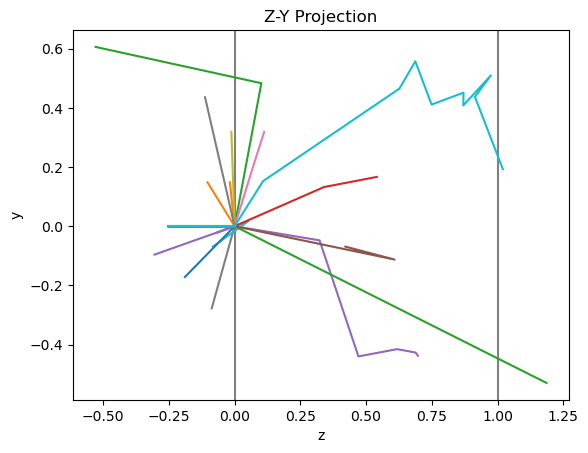

In [19]:
plt.title("Z-Y Projection")
plt.xlabel("z")
plt.ylabel("y")
plt.axline((0,0), (0, -0.5), color='grey')
plt.axline((1,0), (1, -0.5), color='grey')

for i in range(20):
    data = np.genfromtxt('output{:02}.txt'.format(i))
    y = data[:,0]
    z = data[:,2]
    plt.plot(z, y)
    
plt.show()

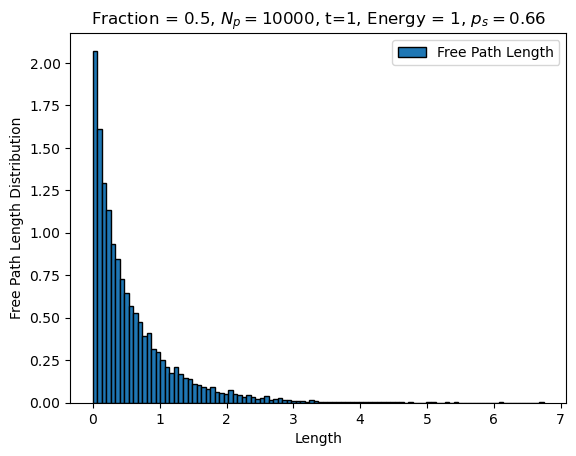

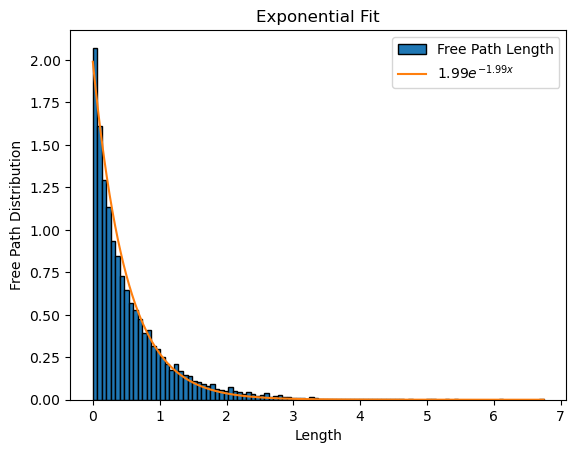

In [20]:
N_S = Neutron_scattering(10000, 1, fraction = 0.5, p_s = 2/3, energy = 1)
N_S.MC_step_inelastic()

fraction = 0.5

res = N_S.free_path

n_bins = 100

H=np.array(res).max()

plt.hist(res, weights = [n_bins/(H*len(res))]*len(res), bins = n_bins, edgecolor = 'black', label = 'Free Path Length')

plt.title('Fraction = {}, $N_p=10000$, t=1, Energy = 1, $p_s=0.66$'.format(fraction))
plt.xlabel('Length')
plt.ylabel('Free Path Length Distribution')
plt.legend()
plt.show()

H=np.array(res).max()

bin_heights, bin_borders, _ = plt.hist(res, weights = [(n_bins)/(H * len(res))] * len(res), bins = n_bins, edgecolor = 'black', label = 'Free Path Length')

bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
popt, _ = curve_fit(exp_, bin_centers, bin_heights)

x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.title('Exponential Fit')
plt.xlabel('Length')
plt.ylabel('Free Path Distribution')
plt.plot(x_interval_for_fit, exp_(x_interval_for_fit, *popt), label = '${:.4} e^{{-{:.4} x}}$'.format(popt[0], popt[0]))
plt.legend()
plt.show()

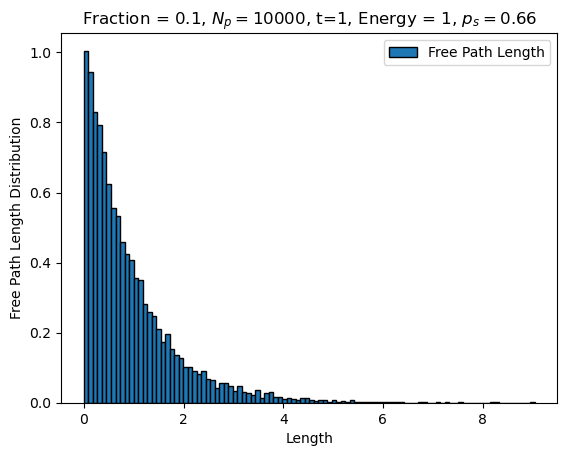

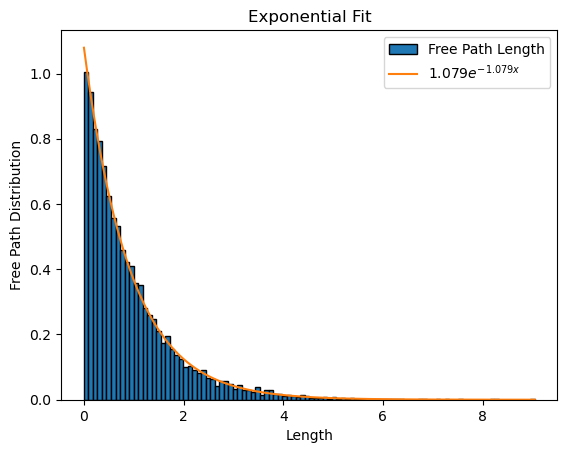

In [21]:
N_S = Neutron_scattering(10000, 1, fraction = 0.1, p_s = 2/3, energy = 1)
N_S.MC_step_inelastic()

res = N_S.free_path

fraction = 0.1

n_bins = 100

H=np.array(res).max()

plt.hist(res, weights = [n_bins/(H*len(res))]*len(res), bins = n_bins, edgecolor = 'black', label = 'Free Path Length')

plt.title('Fraction = {}, $N_p=10000$, t=1, Energy = 1, $p_s=0.66$'.format(fraction))
plt.xlabel('Length')
plt.ylabel('Free Path Length Distribution')
plt.legend()
plt.show()

H=np.array(res).max()

bin_heights, bin_borders, _ = plt.hist(res, weights = [(n_bins)/(H * len(res))] * len(res), bins = n_bins, edgecolor = 'black', label = 'Free Path Length')

bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
popt, _ = curve_fit(exp_, bin_centers, bin_heights)

x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.title('Exponential Fit')
plt.xlabel('Length')
plt.ylabel('Free Path Distribution')
plt.plot(x_interval_for_fit, exp_(x_interval_for_fit, *popt), label = '${:.4} e^{{-{:.4} x}}$'.format(popt[0], popt[0]))
plt.legend()
plt.show()

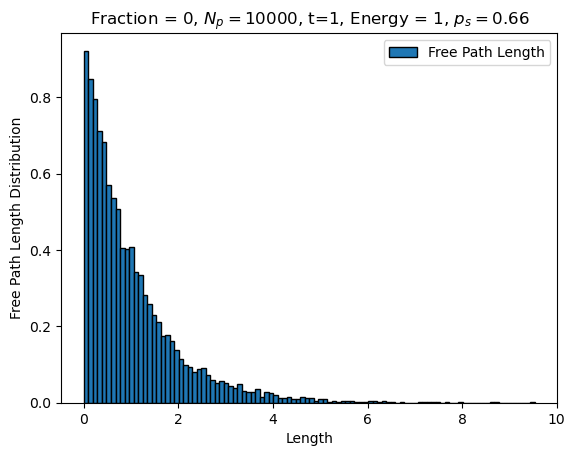

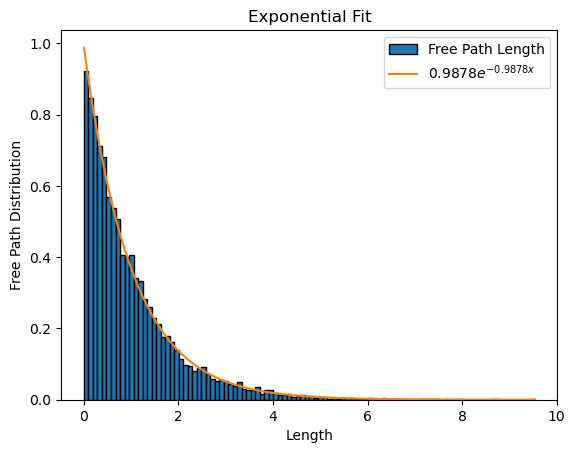

In [22]:
N_S = Neutron_scattering(10000, 1, fraction = 0, p_s = 2/3, energy = 1)
N_S.MC_step_inelastic()

res = N_S.free_path

fraction = 0

n_bins = 100

H=np.array(res).max()

plt.hist(res, weights = [n_bins/(H*len(res))]*len(res), bins = n_bins, edgecolor = 'black', label = 'Free Path Length')

plt.title('Fraction = {}, $N_p=10000$, t=1, Energy = 1, $p_s=0.66$'.format(fraction))
plt.xlabel('Length')
plt.ylabel('Free Path Length Distribution')
plt.legend()
plt.show()

H=np.array(res).max()

bin_heights, bin_borders, _ = plt.hist(res, weights = [(n_bins)/(H * len(res))] * len(res), bins = n_bins, edgecolor = 'black', label = 'Free Path Length')

bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
popt, _ = curve_fit(exp_, bin_centers, bin_heights)

x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.title('Exponential Fit')
plt.xlabel('Length')
plt.ylabel('Free Path Distribution')
plt.plot(x_interval_for_fit, exp_(x_interval_for_fit, *popt), label = '${:.4} e^{{-{:.4} x}}$'.format(popt[0], popt[0]))
plt.legend()
plt.show()

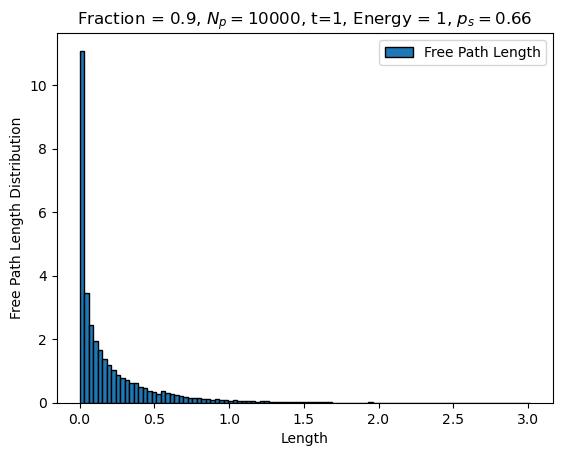

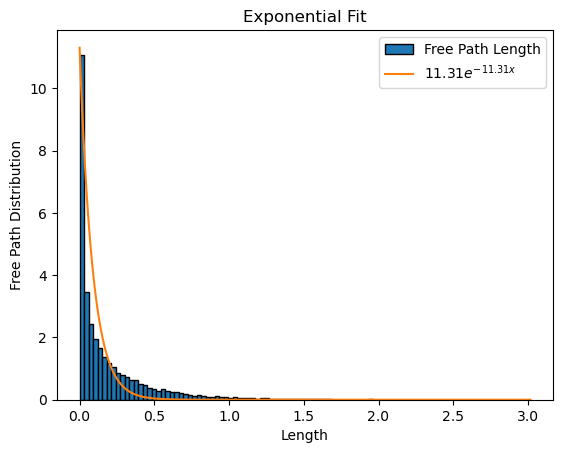

In [23]:
N_S = Neutron_scattering(10000, 1, fraction = 0.9, p_s = 2/3, energy = 1)
N_S.MC_step_inelastic()

res = N_S.free_path

n_bins = 100

fraction = 0.9

H=np.array(res).max()

plt.hist(res, weights = [n_bins/(H*len(res))]*len(res), bins = n_bins, edgecolor = 'black', label = 'Free Path Length')

plt.title('Fraction = {}, $N_p=10000$, t=1, Energy = 1, $p_s=0.66$'.format(fraction))
plt.xlabel('Length')
plt.ylabel('Free Path Length Distribution')
plt.legend()
plt.show()

H=np.array(res).max()

bin_heights, bin_borders, _ = plt.hist(res, weights = [(n_bins)/(H * len(res))] * len(res), bins = n_bins, edgecolor = 'black', label = 'Free Path Length')

bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
popt, _ = curve_fit(exp_, bin_centers, bin_heights)

x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.title('Exponential Fit')
plt.xlabel('Length')
plt.ylabel('Free Path Distribution')
plt.plot(x_interval_for_fit, exp_(x_interval_for_fit, *popt), label = '${:.4} e^{{-{:.4} x}}$'.format(popt[0], popt[0]))
plt.legend()
plt.show()

We see that even in this case, as the fraction of energy increases, the free path distribution tends to follow a Dirac delta distribution.

## Realistic Neutron Scattering

Even though the word "realistic" in this case is misleading and nothing but just a quick way to distinguish from the previous case, we try to develop a more realistic model: the algorithm itself won't change much, but the choice of parameters will.

Suppose we have calculated the capture and scattering cross sections (see e.g. [3]) of the target.
We can consider the probability of scattering and capture as:

\begin{equation}
p_s = \frac{\sigma_s}{\sigma} \quad p_c=\frac{\sigma_c}{\sigma}.
\end{equation}

#### Remark:
- Considering the scattering cross section as a whole is a simplification, we could consider the elastic and inelastic parts and/or the coherent and incoherent parts. 
- The distinction in capture and scattering part is itself a simplification, since for some materials we can even consider a fissile cross section (see e.g. [3].)

From theory (see e.g. [3]), we know that the mean free path of a particle in a medium is given by:

\begin{equation}
\lambda = \frac{1}{N\sigma},
\end{equation}

with $N$ the atomic density number and $\sigma$ the total cross section.  
In order to find the atomic density number, we use:

\begin{equation}
N = \frac{\rho N_A}{M},
\end{equation}

with $\rho$ the density of the material, $N_A$ the Avogadro number and $M$ the molar mass.  
Consequently, the mean free path in cm is given by:

\begin{equation}
\lambda[cm] = \frac{M[g]}{\rho[g/cm^3] N_A \sigma[cm^2]}.
\end{equation}

For our purposes, neutrons will be classified into:
- slow neutrons, which energy range from 0.025 eV to 10 eV;
- fast neutrons, which energy range from 10 eV and above.

Actually this distinction is not complete (and in some nomenclature wrong, see for example [1], [7]) but it is sufficient for our purposes.  
In fact, the scattering cross section seems to be almost constant in the range [10ev, 1MeV] (see [4]), for this reason we will use just two values of the scattering cross section: one for the slow neutrons and one for the fast neutrons.  
On the other hand, the capture cross section is dependent by the inverse square of the incident energy (see [5]):

\begin{equation}
\sigma_c(E) = \sigma_c(E_0) \sqrt{\frac{E_0}{E}}.
\end{equation}

For this reason it is sufficient one value of the capture cross section, but as long as we have two and the dependence seems to be not exactly inverse square dependent, we can use them.  
We will consider 3 elements, representative of moderators ($^{12}$C), absorbers ($^{10}$B) and a halfway ($^{56}$Fe): 

| Target | Scattering Cross Section (Low energy $\approx 10$ eV) | Capture Cross Section (Low energy)| Scattering Cross Section (High energy $\approx 1$ MeV) | Capture Cross Section (High energy)|
|--------------|--------------|:-----------------------------------------------:|----------------------------------------------:|------|
|$^{12}$C            | 5            | 0.002                                               | 2                                            | 0.00001|
|$^{56}$Fe            | 10            | 2                                               | 20                                            | 0.003|
|$^{10}$B            | 5            | 200                                               | 2                                            | 0.4|

A neutron moderator is a medium that reduces the speed of fast neutrons, ideally without capturing any, leaving them as thermal neutrons with only minimal (thermal) kinetic energy.  
In applications such as nuclear reactors, a neutron poison (also called a neutron absorber or a nuclear poison) is a substance with a large neutron absorption cross-section.

The fraction of the energy lost (the energy decrement $\xi$) is depending on the material.     
The related formula is:
\begin{equation}
\xi \approx \frac{2}{A + \frac{2}{3}},
\end{equation}
with $A$ the atomic number of the element.

So we consider the following algorithm:
+ Fix the number of neutrons to be scattered, their energy and the target element;
+ Evaluate the dynamics as in the previous case with the caveat of varying the capture probability according to the inverse square energy.

In [24]:
#Let's see the mean free path lengths

densities = [2.1, 7.9, 2.4]
molar_mass = [12, 56, 10]
sigma_thermal_s = [5, 10, 200]
sigma_thermal_c = [0.002, 2, 5]
sigma_thermal = [5.002, 12, 205]
sigma_fast = [2.0001, 20.003, 2.4]
sigma_fast_s = [2, 20, 2]
sigma_fast_c = [0.0001, 0.003, 0.4]

Avogadro = 6.02*10**23
barn = 10**(-24)
lambda_thermal = []
lambda_fast = []

for i, rho in enumerate(densities):
    lambda_thermal.append(molar_mass[i]/(rho * 60.2 * sigma_thermal[i]))
    lambda_fast.append(molar_mass[i]/(rho * 60.2 * sigma_fast[i]))

print(lambda_thermal)
print(lambda_fast)

[0.018976747222326066, 0.009812579727210282, 0.00033762796099721796]
[0.04745847187944351, 0.005886664836600679, 0.028839055001845703]


In [25]:
class Neutron_scattering_realistic:
    '''
    This class implements 
    the neutron scattering
    '''
    
    def __init__(self, N_p, t, target, energy, fortran = False, store = False, seed = 50):
        'Initialize the neutron scattering'
        self.N_p = N_p
        self.z = np.zeros(N_p)
        self.y = np.zeros(N_p)
        self.x = np.zeros(N_p)
        self.N_r = 0
        self.N_t = 0
        self.N_a = 0
        self.N_s = 0
        self.N_th = 0 #Thermalization counter
        self.mean_free_path = np.zeros(N_p)
        self.t = t
        self.target = target #Neutron beam target: 0 --> 12C, 1 -->56Fe, 2 -->10B 
        self.energy = energy
        self.ts = (0.25/(np.sqrt(2*energy)*10**6))*np.ones(N_p, dtype=np.int32) #We consider flight times, for this reason we include the 0.25cm
        self.energies = np.zeros(N_p)
        self.seed = seed
        self.rng = np.random.default_rng(self.seed)
        self.store = store
        self.fortran = fortran
        if self.fortran == True:
            if self.seed == 50:
                neutronsrf.seed = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]
            else:
                neutronsrf.seed = self.rng.integers(low=0,high=50, size=33)
            neutronsrf.n_p  = self.N_p
            neutronsrf.n_r = self.N_r
            neutronsrf.n_t = self.N_t
            neutronsrf.n_a = self.N_a
            neutronsrf.n_s = self.N_s
            neutronsrf.n_th = self.N_th
            neutronsrf.t = self.t
            neutronsrf.target_ = self.target + 1
            neutronsrf.energy = self.energy
            neutronsrf.store = self.store
            neutronsrf.initial()
            neutronsrf.x = self.x
            neutronsrf.y = self.y
            neutronsrf.z = self.z
            neutronsrf.ts = self.ts
            neutronsrf.energies = self.energies
            neutronsrf.mean_free_path = self.mean_free_path
        
            
    def MC_step_inelastic(self):
        'Monte Carlo dynamics inelastic'
        if self.fortran == True:
            neutronsrf.mc_step_inelastic()
            self.x = neutronsrf.x
            self.y = neutronsrf.y
            self.z = neutronsrf.z
            self.ts = neutronsrf.ts
            self.energies = neutronsrf.energies
            self.mean_free_path = neutronsrf.mean_free_path
            self.N_p = neutronsrf.n_p
            self.N_r = neutronsrf.n_r
            self.N_t = neutronsrf.n_t
            self.N_a = neutronsrf.n_a
            self.N_s = neutronsrf.n_s
            self.N_th = neutronsrf.n_th
        else:
            densities = [2.1, 7.9, 2.4]
            molar_mass = [12, 56, 10]
            sigma_thermal_s = [5, 10, 200] #Scattering cross section for thermal neutrons
            sigma_thermal_c = [0.002, 2, 5] #Capture''''''''''''''''''''''''''''''''''''
            sigma_fast_s = [2, 20, 2] #Scattering cross section for fast neutrons
            sigma_fast_c = [0.0001, 0.003, 0.4] #Capture''''''''''''''''''''''''''''
            xi = [0.16, 0.04, 0.19] #Energy decrement
            for i in range(self.N_p):
                sigma_c_t = sigma_thermal_c
                sigma_c_f = sigma_fast_c
                E = self.energy
                j = self.target
                if self.store:
                    f = open("output{:02}.txt".format(i), "a")
                    f.truncate(0)
                    print(0, 0, -0.25, file=f)
                    print(0, 0, 0, file=f)
                exit = False
                k = 0
                while exit == False:
                    if E <= 0.025: #Thermalization threshold
                        self.N_th = self.N_th + 1 #Thermalization counter increments
                        exit = True
                    if E >= 10: #Check if the neutron is fast
                        sigma_c = sigma_fast_c[j] * (1000/np.sqrt(E)) #Energy dependence of capture cross section
                        sigma_tot = sigma_fast_s[j] + sigma_c #Total scattering cross section changes
                        p_s = sigma_fast_s[j]/sigma_tot #Scattering probability changes
                        lambda_ = molar_mass[j]/(densities[j] * 60.2 * sigma_tot) #Mean free path changes
                    else: #Check if the neutron is thermal
                        sigma_c = sigma_thermal_c[j] * (3.2/np.sqrt(E))
                        sigma_tot = sigma_fast_s[j] + sigma_c
                        p_s = sigma_thermal_s[j]/sigma_tot
                        lambda_ = molar_mass[j]/(densities[j] * 60.2 * sigma_tot)
                    rnd = self.rng.random()
                    if rnd <= p_s:
                        self.N_s = self.N_s + 1
                        k = k + 1
                        E = (1 - xi[j]) * E
                        rnd_ = self.rng.random(3)
                        l = - lambda_ * np.log(rnd_[0])
                        v = np.sqrt(2*E)*10**6
                        self.ts[i] = self.ts[i] + l/v
                        self.mean_free_path[i] = (l + self.mean_free_path[i])/k
                        phi = 2 * np.pi * rnd_[1]
                        cos_theta = 1 - 2 * rnd_[2]
                        theta = np.arccos(cos_theta)
                        self.z[i] = l * cos_theta + self.z[i]
                        if self.store:
                            self.x[i] = l * np.sin(theta) * np.cos(phi) + self.x[i]
                            self.y[i] = l * np.sin(theta) * np.sin(phi) + self.y[i]
                            print(self.x[i], self.y[i], self.z[i], file=f)
                        if self.z[i] < 0:
                            self.N_r += 1
                            exit = True
                        if self.z[i] > self.t:
                            self.N_t = self.N_t+1
                            exit = True
                    else:
                        self.N_a = self.N_a+1
                        exit = True
                self.energies[i] = E
                if self.store:
                    f.close()
                    
    def deallocate_(self):
        neutronsrf.deallocate_()
    
    def get_stats(self,display=True):
        '''
        Calculate, store and print 
        statistical quantities
        '''
        self.p_refr = self.N_r/self.N_p
        self.p_tras = self.N_t/self.N_p
        self.p_abso = self.N_a/self.N_p
        self.p_ther = self.N_th/self.N_p

In [26]:
N_S=Neutron_scattering_realistic(N_p = 100, t = 1, target = 0, energy = 1000000, store = True)
N_S.MC_step_inelastic()

print('Target: C')
print('Number of neutrons:', 100)
print('t: 1 cm')
print('Energy: 1 MeV')
print('Mean time:', np.mean(N_S.ts), 's')
print("Scattering events:", N_S.N_s)
print('Mean free path:', np.mean(N_S.mean_free_path), 'cm')
print('Mean energy:', np.mean(N_S.energies), 'eV')
print('Min energy:', N_S.energies.min(), 'eV')
print('Max energy:', N_S.energies.max(), 'eV')

Target: C
Number of neutrons: 100
t: 1 cm
Energy: 1 MeV
Mean time: 9.344467814979198e-08 s
Scattering events: 696
Mean free path: 0.03502179957731657 cm
Mean energy: 652419.0973651903 eV
Min energy: 0.018901104285804046 eV
Max energy: 840000.0 eV


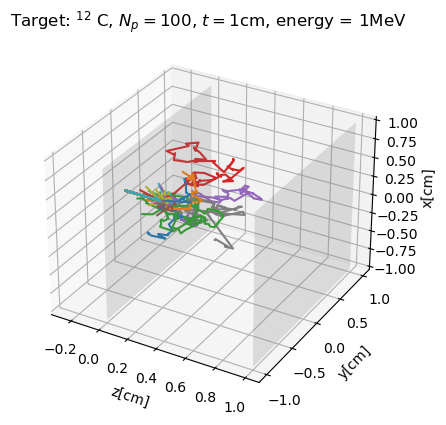

In [27]:
fig = plt.figure()
ax = plt.axes(projection ="3d")
plt.title("Target: $^{12}$ C, $N_p=100$, $t = 1$cm, energy = 1MeV")

point  = np.array([0, 0, 0])
normal = np.array([1, 0, 0])
point_  = np.array([1, 0, 0])

# a plane is a*x+b*y+c*z+d=0
# [a,b,c] is the normal. Thus, we have to calculate
# d and we're set
d = -point.dot(normal)
d_ = -point_.dot(normal)

# create x,y
zz, yy = np.meshgrid(np.linspace(-1,1,10), np.linspace(-1,1,10))

# calculate corresponding z
x = (-normal[2] * zz - normal[1] * yy - d) * 1. /normal[0]
x_ = (-normal[2] * zz - normal[1] * yy - d_) * 1. /normal[0]
ax.plot_surface(x, yy, zz, alpha=0.2,color='grey')
ax.plot_surface(x_, yy, zz, alpha=0.2,color='grey')
ax.set_xlabel('z[cm]')
ax.set_ylabel('y[cm]')
ax.set_zlabel('x[cm]')

for i in range(100):
    data = np.genfromtxt('output{:02}.txt'.format(i))
    x = data[:,0]
    y = data[:,1]
    z = data[:,2]
    ax.plot3D(z, y, x)

plt.show()

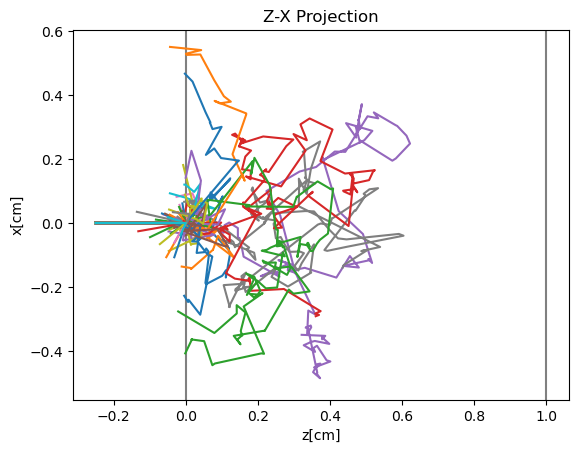

In [28]:
plt.title("Z-X Projection")
plt.xlabel("z[cm]")
plt.ylabel("x[cm]")
plt.axline((0,0), (0, -0.5), color='grey')
plt.axline((1,0), (1, -0.5), color='grey')

for i in range(100):
    data = np.genfromtxt('output{:02}.txt'.format(i))
    x = data[:,1]
    z = data[:,2]
    plt.plot(z, x)
    
plt.show()

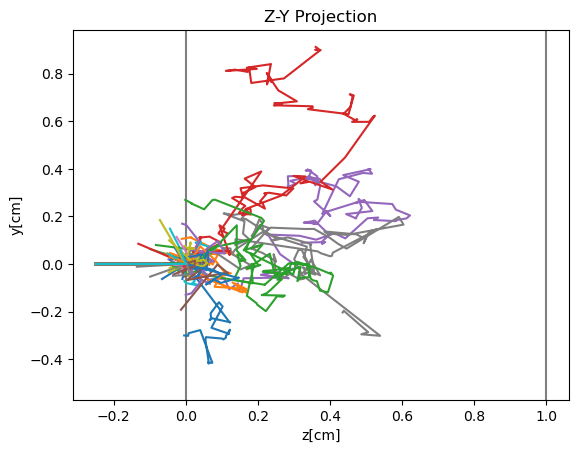

In [29]:
plt.title("Z-Y Projection")
plt.xlabel("z[cm]")
plt.ylabel("y[cm]")
plt.axline((0,0), (0, -0.5), color='grey')
plt.axline((1,0), (1, -0.5), color='grey')

for i in range(100):
    data = np.genfromtxt('output{:02}.txt'.format(i))
    y = data[:,0]
    z = data[:,2]
    plt.plot(z, y)
    
plt.show()

We see that $^{12}$C is particulary effective in slowing down the incoming neutrons: their trajectories are spread inside the matter, resulting in many scattering events, which means more energy lost.

In [30]:
N_S=Neutron_scattering_realistic(N_p = 100, t = 1, target = 1, energy = 1000000, store = True)
N_S.MC_step_inelastic()

print('Target: Fe')
print('Number of neutrons:', 100)
print('t: 1 cm')
print('Energy: 1 MeV')
print('Mean time:', np.mean(N_S.ts), 's')
print("Scattering events:", N_S.N_s)
print('Mean free path:', np.mean(N_S.mean_free_path), 'cm')
print('Mean energy:', np.mean(N_S.energies), 'eV')
print('Min energy:', N_S.energies.min(), 'eV')
print('Max energy:', N_S.energies.max(), 'eV')

Target: Fe
Number of neutrons: 100
t: 1 cm
Energy: 1 MeV
Mean time: 1.5504246622516578e-09 s
Scattering events: 1535
Mean free path: 0.0036815302105375493 cm
Mean energy: 799542.9574033475 eV
Min energy: 12.278110905812195 eV
Max energy: 960000.0 eV


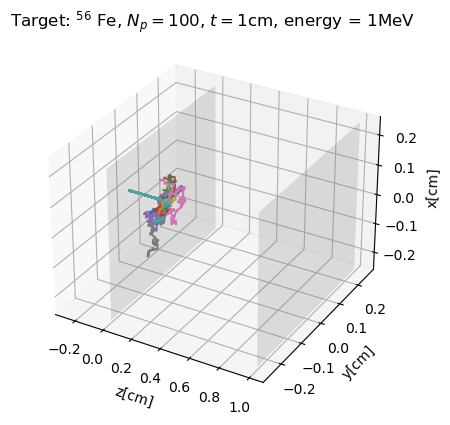

In [31]:
fig = plt.figure()
ax = plt.axes(projection ="3d")
plt.title("Target: $^{56}$ Fe, $N_p=100$, $t = 1$cm, energy = 1MeV")

point  = np.array([0, 0, 0])
normal = np.array([1, 0, 0])
point_  = np.array([1, 0, 0])

# a plane is a*x+b*y+c*z+d=0
# [a,b,c] is the normal. Thus, we have to calculate
# d and we're set
d = -point.dot(normal)
d_ = -point_.dot(normal)

# create x,y
zz, yy = np.meshgrid(np.linspace(-0.25,0.25,10), np.linspace(-0.25,0.25,10))

# calculate corresponding z
x = (-normal[2] * zz - normal[1] * yy - d) * 1. /normal[0]
x_ = (-normal[2] * zz - normal[1] * yy - d_) * 1. /normal[0]
ax.plot_surface(x, yy, zz, alpha=0.2,color='grey')
ax.plot_surface(x_, yy, zz, alpha=0.2,color='grey')
ax.set_xlabel('z[cm]')
ax.set_ylabel('y[cm]')
ax.set_zlabel('x[cm]')

for i in range(100):
    data = np.genfromtxt('output{:02}.txt'.format(i))
    x = data[:,0]
    y = data[:,1]
    z = data[:,2]
    ax.plot3D(z, y, x)

plt.show()

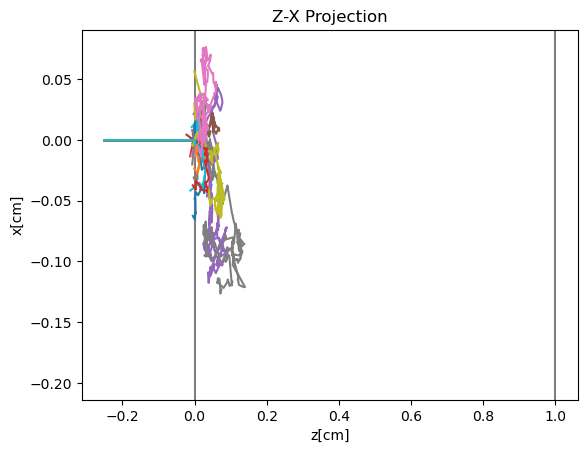

In [32]:
plt.title("Z-X Projection")
plt.xlabel("z[cm]")
plt.ylabel("x[cm]")
plt.axline((0,0), (0, -0.2), color='grey')
plt.axline((1,0), (1, -0.2), color='grey')

for i in range(100):
    data = np.genfromtxt('output{:02}.txt'.format(i))
    x = data[:,1]
    z = data[:,2]
    plt.plot(z, x)
    
plt.show()

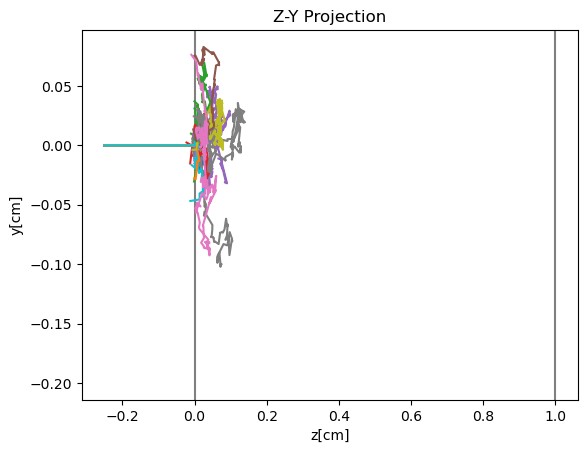

In [33]:
plt.title("Z-Y Projection")
plt.xlabel("z[cm]")
plt.ylabel("y[cm]")
plt.axline((0,0), (0, -0.2), color='grey')
plt.axline((1,0), (1, -0.2), color='grey')

for i in range(100):
    data = np.genfromtxt('output{:02}.txt'.format(i))
    y = data[:,0]
    z = data[:,2]
    plt.plot(z, y)
    
plt.show()

We see that since for fast neutrons $^{56}$Fe behaves like a moderator, at the beginning the neutrons undergo many scattering events, but then--as neutrons are slowed down-- the capture cross section grows and these neutrons are captured.  
This explains why trajectories are less spread than in the $^{10}$C.

In [34]:
N_S=Neutron_scattering_realistic(N_p = 100, t = 1, target = 2, energy = 1000000, store = True)
N_S.MC_step_inelastic()

print('Target: B')
print('Number of neutrons:', 100)
print('t: 1 cm')
print('Energy: 1 MeV')
print('Mean time:', np.mean(N_S.ts), 's')
print("Scattering events:", N_S.N_s)
print('Mean free path:', np.mean(N_S.mean_free_path), 'cm')
print('Mean energy:', np.mean(N_S.energies), 'eV')
print('Min energy:', N_S.energies.min(), 'eV')
print('Max energy:', N_S.energies.max(), 'eV')

Target: B
Number of neutrons: 100
t: 1 cm
Energy: 1 MeV
Mean time: 2.21559852461734e-10 s
Scattering events: 168
Mean free path: 0.02174860443081864 cm
Mean energy: 737771.2360483718 eV
Min energy: 121576.65459056935 eV
Max energy: 1000000.0 eV


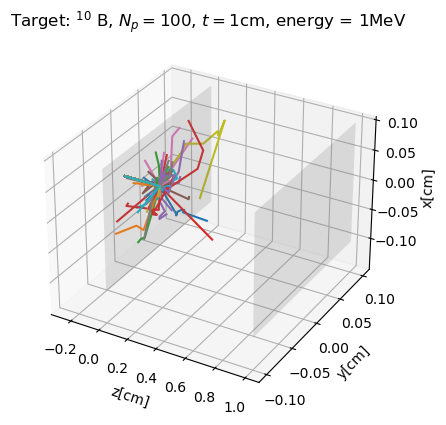

In [35]:
fig = plt.figure()
ax = plt.axes(projection ="3d")
plt.title("Target: $^{10}$ B, $N_p=100$, $t = 1$cm, energy = 1MeV")

point  = np.array([0, 0, 0])
normal = np.array([1, 0, 0])
point_  = np.array([1, 0, 0])

# a plane is a*x+b*y+c*z+d=0
# [a,b,c] is the normal. Thus, we have to calculate
# d and we're set
d = -point.dot(normal)
d_ = -point_.dot(normal)

# create x,y
zz, yy = np.meshgrid(np.linspace(-0.1, 0.1, 10), np.linspace(-0.1, 0.1, 10))

# calculate corresponding z
x = (-normal[2] * zz - normal[1] * yy - d) * 1. /normal[0]
x_ = (-normal[2] * zz - normal[1] * yy - d_) * 1. /normal[0]
ax.plot_surface(x, yy, zz, alpha=0.2,color='grey')
ax.plot_surface(x_, yy, zz, alpha=0.2,color='grey')
ax.set_xlabel('z[cm]')
ax.set_ylabel('y[cm]')
ax.set_zlabel('x[cm]')

for i in range(100):
    data = np.genfromtxt('output{:02}.txt'.format(i))
    x = data[:,0]
    y = data[:,1]
    z = data[:,2]
    ax.plot3D(z, y, x)

plt.show()

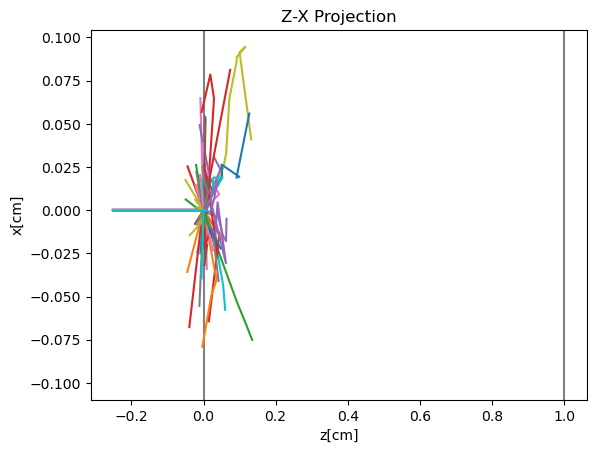

In [36]:
plt.title("Z-X Projection")
plt.xlabel("z[cm]")
plt.ylabel("x[cm]")
plt.axline((0,0), (0, -0.1), color='grey')
plt.axline((1,0), (1, -0.1), color='grey')

for i in range(100):
    data = np.genfromtxt('output{:02}.txt'.format(i))
    x = data[:,1]
    z = data[:,2]
    plt.plot(z, x)
    
plt.show()

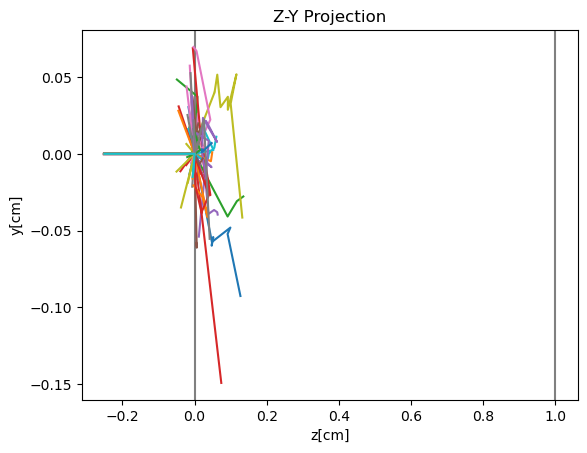

In [37]:
plt.title("Z-Y Projection")
plt.xlabel("z[cm]")
plt.ylabel("y[cm]")
plt.axline((0,0), (0, -0.1), color='grey')
plt.axline((1,0), (1, -0.1), color='grey')

for i in range(100):
    data = np.genfromtxt('output{:02}.txt'.format(i))
    y = data[:,0]
    z = data[:,2]
    plt.plot(z, y)
    
plt.show()

In this case, since capture cross section is bigger, neutrons will face fewer scattering events: despite this, the trajectories can reach about 20% of the length, this is due to the long mean free path of $^{10}B$.

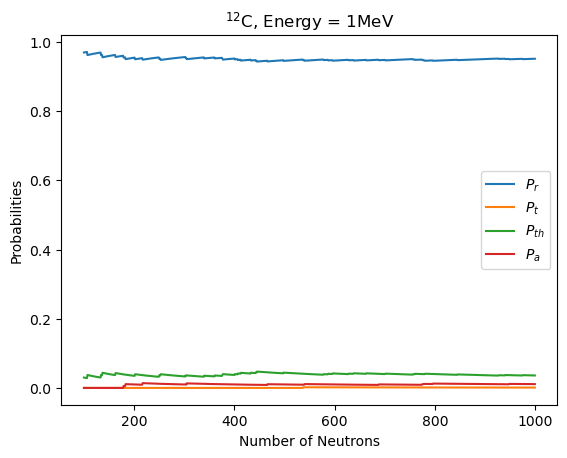

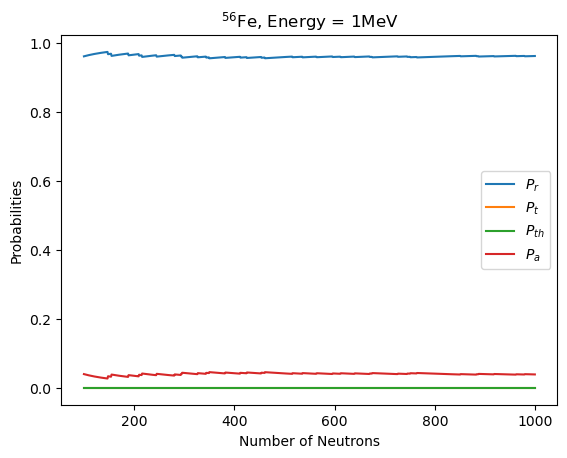

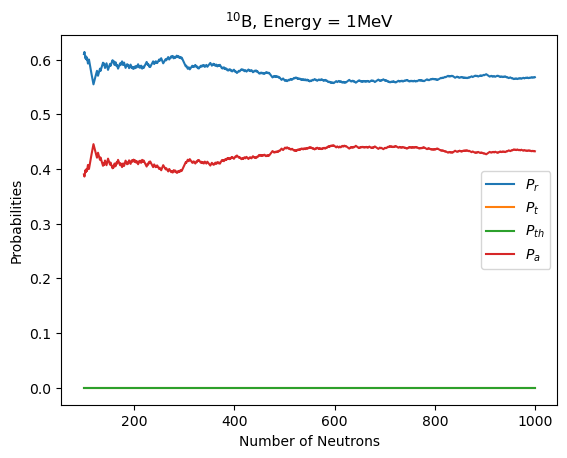

In [38]:
P_r=[]
P_t=[]
P_th=[]
P_a=[]
N_p=[]
for i in range(100,1000):
    N_S=Neutron_scattering_realistic(i, t = 1, target = 0, energy = 1000000)
    N_S.MC_step_inelastic()
    N_S.get_stats()
    P_r.append(N_S.p_refr)
    P_t.append(N_S.p_tras)
    P_th.append(N_S.p_ther)
    P_a.append(N_S.p_abso)
    N_p.append(i)
    
plt.title("$^{12}$C, Energy = 1MeV")
plt.xlabel("Number of Neutrons")
plt.ylabel("Probabilities")
plt.plot(N_p,P_r,label='$P_r$')
plt.plot(N_p,P_t,label='$P_t$')
plt.plot(N_p,P_th,label='$P_{th}$')
plt.plot(N_p,P_a,label='$P_a$')
plt.legend()
plt.show()

P_r=[]
P_t=[]
P_th=[]
P_a=[]
N_p=[]
for i in range(100,1000):
    N_S=Neutron_scattering_realistic(i, t = 1, target = 1, energy = 1000000)
    N_S.MC_step_inelastic()
    N_S.get_stats()
    P_r.append(N_S.p_refr)
    P_t.append(N_S.p_tras)
    P_th.append(N_S.p_ther)
    P_a.append(N_S.p_abso)
    N_p.append(i)
    
plt.title("$^{56}$Fe, Energy = 1MeV")
plt.xlabel("Number of Neutrons")
plt.ylabel("Probabilities")
plt.plot(N_p,P_r,label='$P_r$')
plt.plot(N_p,P_t,label='$P_t$')
plt.plot(N_p,P_th,label='$P_{th}$')
plt.plot(N_p,P_a,label='$P_a$')
plt.legend()
plt.show()

P_r=[]
P_t=[]
P_th=[]
P_a=[]
N_p=[]
for i in range(100,1000):
    N_S=Neutron_scattering_realistic(i, t = 1, target = 2, energy = 1000000)
    N_S.MC_step_inelastic()
    N_S.get_stats()
    P_r.append(N_S.p_refr)
    P_t.append(N_S.p_tras)
    P_th.append(N_S.p_ther)
    P_a.append(N_S.p_abso)
    N_p.append(i)
    
plt.title("$^{10}$B, Energy = 1MeV")
plt.xlabel("Number of Neutrons")
plt.ylabel("Probabilities")
plt.plot(N_p,P_r,label='$P_r$')
plt.plot(N_p,P_t,label='$P_t$')
plt.plot(N_p,P_th,label='$P_{th}$')
plt.plot(N_p,P_a,label='$P_a$')
plt.legend()
plt.show()

In the carbon case, over the 90% of the neutrons are reflected, this is due to the fact that collisions take place at the beginning of the material, so on average one half of the particles which $z$ coordinate is less than the mean free path is reflected. The remaining neutrons will be slowed down.  
In the iron case this feature is even more stressed: since there is a larger capture cross section, neutrons that have $z$ coordinate bigger than the mean free path will be captured.  
In the boron case the capture and reflection probabilities are almost equal.

Target: C
Number of neutrons: 100
t: 1 cm
Energy: 1 MeV
Mean time: 1.0804492e-07 s
Scattering events: 914
Mean free path: 0.03753381 cm
Mean energy: 630252.2 eV
Min energy: 0.01890118 eV
Max energy: 840000.06 eV


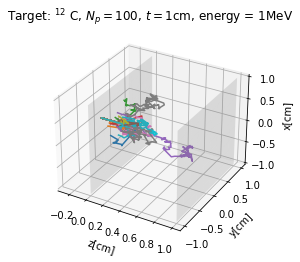

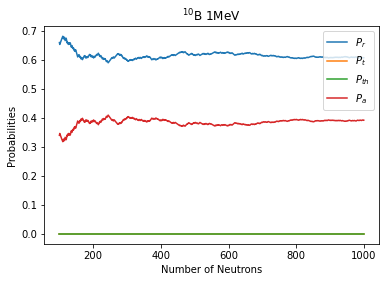

In [39]:
#Fortran runs

N_S=Neutron_scattering_realistic(N_p = 100, t = 1.0, target = 0, energy = 1000000.0, fortran = True, store = True)
N_S.MC_step_inelastic()

print('Target: C')
print('Number of neutrons:', 100)
print('t: 1 cm')
print('Energy: 1 MeV')
print('Mean time:', np.mean(N_S.ts), 's')
print("Scattering events:", N_S.N_s)
print('Mean free path:', np.mean(N_S.mean_free_path), 'cm')
print('Mean energy:', np.mean(N_S.energies), 'eV')
print('Min energy:', N_S.energies.min(), 'eV')
print('Max energy:', N_S.energies.max(), 'eV')

N_S.deallocate_()

fig = plt.figure()
ax = plt.axes(projection ="3d")
plt.title("Target: $^{12}$ C, $N_p=100$, $t = 1$cm, energy = 1MeV")

point  = np.array([0, 0, 0])
normal = np.array([1, 0, 0])
point_  = np.array([1, 0, 0])

# a plane is a*x+b*y+c*z+d=0
# [a,b,c] is the normal. Thus, we have to calculate
# d and we're set
d = -point.dot(normal)
d_ = -point_.dot(normal)

# create x,y
zz, yy = np.meshgrid(np.linspace(-1,1,10), np.linspace(-1,1,10))

# calculate corresponding z
x = (-normal[2] * zz - normal[1] * yy - d) * 1. /normal[0]
x_ = (-normal[2] * zz - normal[1] * yy - d_) * 1. /normal[0]
ax.plot_surface(x, yy, zz, alpha=0.2,color='grey')
ax.plot_surface(x_, yy, zz, alpha=0.2,color='grey')
ax.set_xlabel('z[cm]')
ax.set_ylabel('y[cm]')
ax.set_zlabel('x[cm]')

for i in range(100):
    data = np.genfromtxt('output{:02}.txt'.format(i))
    x = data[:,0]
    y = data[:,1]
    z = data[:,2]
    ax.plot3D(z, y, x)

plt.show()

P_r=[]
P_t=[]
P_th=[]
P_a=[]
N_p=[]
for i in range(100,1000):
    N_S=Neutron_scattering_realistic(i, t = 1.0, target = 2, energy = 1000000.0, fortran = True)
    N_S.MC_step_inelastic()
    N_S.get_stats()
    P_r.append(N_S.p_refr)
    P_t.append(N_S.p_tras)
    P_th.append(N_S.p_ther)
    P_a.append(N_S.p_abso)
    N_S.deallocate_()
    N_p.append(i)
    
plt.title("$^{10}$B 1MeV")
plt.xlabel("Number of Neutrons")
plt.ylabel("Probabilities")
plt.plot(N_p,P_r,label='$P_r$')
plt.plot(N_p,P_t,label='$P_t$')
plt.plot(N_p,P_th,label='$P_{th}$')
plt.plot(N_p,P_a,label='$P_a$')
plt.legend()
plt.show()

We see that fortran runs give almost the same results.

In [40]:
#Line profiler comparison fortran vs. python

%load_ext line_profiler

In [41]:
N_S=Neutron_scattering_realistic(N_p = 100000, t = 1.0, target = 0, energy = 1000000.0, fortran = True)
%lprun -f N_S.MC_step_inelastic N_S.MC_step_inelastic()
N_S.deallocate_()

Timer unit: 1e-09 s

Total time: 0.0489743 s
File: /tmp/ipykernel_93/2258591383.py
Function: MC_step_inelastic at line 52

Line #      Hits         Time  Per Hit   % Time  Line Contents
    52                                               def MC_step_inelastic(self):
    53                                                   'Monte Carlo dynamics inelastic'
    54         1       1747.0   1747.0      0.0          if self.fortran == True:
    55         1   48934106.0 48934106.0     99.9              neutronsrf.mc_step_inelastic()
    56         1       5564.0   5564.0      0.0              self.x = neutronsrf.x
    57         1       1736.0   1736.0      0.0              self.y = neutronsrf.y
    58         1       1974.0   1974.0      0.0              self.z = neutronsrf.z
    59         1       1933.0   1933.0      0.0              self.ts = neutronsrf.ts
    60         1      18464.0  18464.0      0.0              self.energies = neutronsrf.energies
    61         1       1834.0   183

In [42]:
N_S=Neutron_scattering_realistic(N_p = 100000, t = 1.0, target = 0, energy = 1000000.0)
%lprun -f N_S.MC_step_inelastic N_S.MC_step_inelastic()

Timer unit: 1e-09 s

Total time: 24.6262 s
File: /tmp/ipykernel_93/2258591383.py
Function: MC_step_inelastic at line 52

Line #      Hits         Time  Per Hit   % Time  Line Contents
    52                                               def MC_step_inelastic(self):
    53                                                   'Monte Carlo dynamics inelastic'
    54         1        827.0    827.0      0.0          if self.fortran == True:
    55                                                       neutronsrf.mc_step_inelastic()
    56                                                       self.x = neutronsrf.x
    57                                                       self.y = neutronsrf.y
    58                                                       self.z = neutronsrf.z
    59                                                       self.ts = neutronsrf.ts
    60                                                       self.energies = neutronsrf.energies
    61                                 

In particular the fortran implementation is much faster (about $\frac{24.6262}{0.0489743} \approx 500$ times) than the Python one.

### Bibliography

[1] https://en.wikipedia.org/wiki/Neutron_temperature

[2] https://en.wikipedia.org/wiki/Neutron_moderator

[3] https://en.wikipedia.org/wiki/Neutron_cross_section  

[4] https://www.ncnr.nist.gov/resources/n-lengths/

[5] J. Chem. Theory Comput. 2020, 16, 5212−5217

[6]https://en.wikipedia.org/wiki/Neutron_cross_section#/media/File:Common_light_element_moderators,_reflectors_and_absorbers.svg

[7] https://www.nuclear-power.com/nuclear-power/reactor-physics/atomic-nuclear-physics/fundamental-particles/neutron/neutron-energy/